## EM Algorithm (2023)

On souhaite appliquer l'algorithme EM sur une mixture unidimensionnelle de 2 Gaussiennes, avec pour moyennes, variances et proportions respectives:  $\mu_1 = 0$, $\mu_2 = 4$, $\sigma_1 = 1$, $\sigma_2 = \frac{1}{2}$ et $\pi_1 = \frac{1}{3}$

On note N la taille de la mixture et $X = (x_1, x_2, ..., x_N)$ un échantillon de la mixture.

Pour cela, nous allons d'abord implémenter un algorithme EM générique gaussien avec un nombre $K$ inconnu de distributions gaussiennes ($K \le N$) puis l'appliquer à notre cas particulier.

On note $N(x; \mu, \sigma)$ la distribution gaussienne et $\Theta^{(q)} = (\mu_1^{(q)}, ... ,\mu_K^{(q)}, \sigma_1^{(q)}, ...,  \sigma_K^{(q)}, \pi_1^{(q)}, ..., \pi_K^{(q)})$ les paramètres calculés à la $(q)$ ème itération, où $\forall (q), \sum_{k=1}^{K} \pi_k^{(q)} = 1$.

La mixture est donc sous la forme:
$$
\sum_{j = 1}^{j = K} \pi_j^{(q)} * N(x_i, \mu_j^{(q)}, \sigma_j^{(q)})
$$


## Initialisation de l'algorithme EM

Arbitrairement, on pose des valeurs initiales pour $\Theta^{(0)}$ tels que:
- $\forall k \in \{1, ..., K\}, \mu_k^{(0)}$ vaut un élément de $X$ choisi aléatoirement selon une loi uniforme ($\mu_k^{(0)} = x_i \ où \ i$ ~ $U(\{1, ..., N\})$),
- $\forall k \in \{1, ..., K\}, \sigma_k^{(0)} = 1$,
- $\forall k \in \{1, ..., K\}, \pi_k^{(0)} = \frac{1}{K}$.


Dans la suite, on considèrera: 
- $\forall i \in \{1, ..., N\}, \forall k \in \{1, ..., K\}, z_{i,k}$, la variable latente binaire associé à la composante $x_i$ et qui indique si $x_i$ provient de la distribution $k$.
- $\forall i \in \{1, ..., N\}, \forall k \in \{1, ..., K\}, t_{i,k} = \mathbb{P}(z_{i,k} = 1 | X_i = x_i)$, la probabilité conditionnelle que $z_{i,k} = 1$ sachant $x_i$.

On note l'indice ($q$), qui indique la $q^{ème}$ de l'itération.



In [17]:
##==============================================================================
# Imports
##==============================================================================
import numpy as np
import matplotlib.pyplot as plt
import random

In [80]:
##==============================================================================
# Class Gaussian
#
# Cette classe permet de créer une distribution gaussienne à partir de sa moyenne et de sa variance
##==============================================================================
class Gaussian():
    def __init__(self, mu, sigma2):
        self.mu = mu
        self.sigma2 = sigma2

    def __repr__(self):
        return f"Gaussian(µ={self.mu}, σ²={self.sigma2})"

    def pdf(self, x):
        return (1 / (self.sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mu) / self.sigma2) ** 2)

    def plot_pdf(self, x_min, x_max):
        x = np.linspace(x_min, x_max, 100)
        y = self.pdf(x)
        plt.plot(x, y, label=self.__repr__())
        plt.grid()
        plt.legend()

## E-step

On a:
$$
\forall i \in \{1, ..., N\}, \forall k \in \{1, ..., K\}, \forall (q), t_{i, k}^{(q)} = \frac{\pi_k^{(q)} * N(x_i, \mu_k^{(q)}, \sigma_k^{(q)})}{\sum_{j = 1}^{j = K} \pi_j^{(q)} * N(x_i, \mu_j^{(q)}, \sigma_j^{(q)})}
$$

*Justification:* On utilise la formule de Bayes. 

On calcule ensuite l'expression $Q(\Theta, \Theta^{(q)}) = \mathbb{E}_{Z|X, \Theta^{(q)}}[log(P(X, Z; \Theta))]$, où $log(P(X, Z; \Theta))$ est la log-vraisemblance de la mixture.

Dans le cas de distributions gaussiens, on a: $Q(\Theta, \Theta^{(q)}) = \mathbb{E}_{Z|X, \Theta^{(q)}} [log(\prod_{i = 1}^{i = N} \sum_{k = 1}^{k = K} \pi_k^{(q)} * N(x_i, \mu_k^{(q)}, \sigma_k^{(q)}))] \\$
$= \mathbb{E}_{Z|X, \Theta^{(q)}} [log(\prod_{i = 1}^{i = N} \prod_{k = 1}^{k = K} (\pi_k^{(q)} * N(x_i, \mu_k^{(q)}, \sigma_k^{(q)}))^{\mathbf{1[z_{i,k} = 1]}})]$
$$= \sum_{i = 1}^{i = N} \sum_{k = 1}^{k = K} \mathbb{E}_{Z|X, \Theta^{(q)}} [\mathbb{1[z_{i,k} = 1]}] (log(\pi_k^{(q)}) + log(\frac{1}{\sqrt{2\pi}\sigma_k^{(q)}}) + \frac{(- (x_i - \mu_k^{(q)})^2)}{2(\sigma_k^{(q)})^2})
$$
$$= \sum_{i = 1}^{i = N} \sum_{k = 1}^{k = K} t_{i,k}^{(q)} (log(\pi_k^{(q)}) + log(\frac{1}{\sqrt{2\pi}\sigma_k^{(q)}}) + \frac{(- (x_i - \mu_k^{(q)})^2)}{2(\sigma_k^{(q)})^2})
$$

In [81]:
##==============================================================================
## Fonction E_step
##
## Paramètres :
##      mu : liste des moyennes à l'itération (q)  (taille K)
##      sigma : liste des variances à l'itération (q)  (taille K)
##      pi : liste des poids à l'itération (q)  (taille K)
##      mixture : liste des données  (taille N)
##
## Retour :
##      Q : valeur de l'expression Q à l'itération courante
##      tik_list : liste des tik à l'itération courante (taille K x N)
##==============================================================================
def E_step(mu:list, sigma:list, pi:list, mixture):
    gaussian_list = []
    tik_list = np.zeros((len(mu), len(mixture)))
    Q = 0
    for k in range(len(mu)):
        gaussian_list.append(Gaussian(mixture, mu[k], sigma[k]))
        tik_list[k] = pi[k] * gaussian_list[k]  # Numérateur de tik

    # Division par le dénominateur de tik
    tik_list /= np.sum(tik_list, axis=0)

    # Calcul de la fonction Q
    Q = np.sum(tik_list * np.log(np.array([pi[k] * gaussian_list[k] for k in range(len(mu))])))

    return Q, tik_list

In [20]:
mu1 = 0
mu2 = 4
sigma1 = 1
sigma2 = 1/2
pi1 = 1/3
n = 1000

Z = np.zeros(n)
mixture = np.zeros(n)

for k in range(0, n):
    tmp = np.random.choice([1, 2], p=[pi1, 1 - pi1])
    Z[k] = tmp
    if tmp == 1:
        mixture[k] = np.random.normal(mu1, sigma1)
    else:
        mixture[k] = np.random.normal(mu2, sigma2)

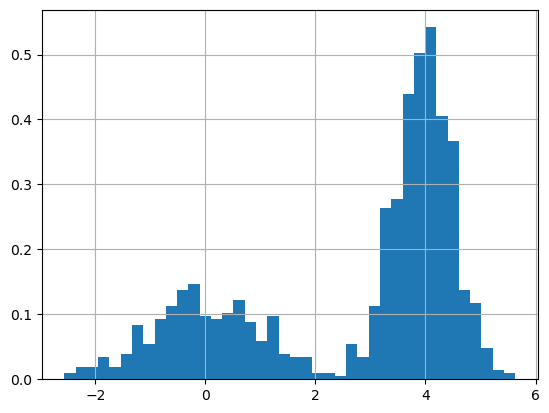

In [21]:
plt.grid()
plt.hist(mixture, bins=40, density=True)
plt.show()


# Initialisation

In [102]:
n = 1000

mu1_list = np.array([mixture[random.randint(0, n - 1)]])
mu2_list = np.array([mixture[random.randint(0, n - 1)]])
sigma1_list = np.array([1])
sigma2_list = np.array([1])
pi1_list = np.array([0.4])
ti1_list = np.array([0] * n)
Q = np.array([])

criteria = 10**(-6)

# E Step

In [105]:
def Gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def EM(mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list, Q, mixture):
    
    E = E_step([mu1_list[-1], mu2_list[-1]], [sigma1_list[-1], sigma2_list[-1]], [pi1_list[-1], 1 - pi1_list[-1]], mixture)
    Q = np.append(Q, E[0])
    ti1_list = E[1]
    print(Q)
    # M-step
    if (len(Q) == 1 or (np.linalg.norm(np.array([mu1_list[-1], mu2_list[-1], sigma1_list[-1], sigma2_list[-1], pi1_list[-1]]) - np.array([mu1_list[-2], mu2_list[-2], sigma1_list[-2], sigma2_list[-2], pi1_list[-2]])) ** 2 / np.linalg.norm(np.array([mu1_list[-2], mu2_list[-2], sigma1_list[-2], sigma2_list[-2], pi1_list[-2]])) ** 2) > criteria):
        mu1_list = np.append(mu1_list, np.sum(ti1_list * mixture) / np.sum(ti1_list))
        mu2_list = np.append(mu2_list, np.sum((1 - ti1_list) * mixture) / np.sum(1 - ti1_list))
        sigma1_list = np.append(sigma1_list, np.sqrt(np.sum(ti1_list * (mixture - mu1_list[-1]) ** 2) / np.sum(ti1_list)))
        sigma2_list = np.append(sigma2_list, np.sqrt(np.sum((1 - ti1_list) * (mixture - mu2_list[-1]) ** 2) / np.sum(1 - ti1_list)))
        pi1_list = np.append(pi1_list, np.sum(ti1_list) / n)
        return EM(mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list, Q, mixture)
    else:
        return mu1_list[-1], mu2_list[-1], sigma1_list[-1], sigma2_list[-1], pi1_list[-1]
        

In [107]:
em = EM(mu1_list, mu2_list, sigma1_list, sigma2_list, pi1_list, Q, mixture)
print("Il y a convergence: mu1 = {}, mu2 = {}, sigma1 = {}, sigma2 = {}, pi1 = {}".format(em[0], em[1], em[2], em[3], em[4]))

[-4058.0676338]
[-4058.0676338           nan]
[-4058.0676338           nan           nan]
Il y a convergence: mu1 = 2.7002655600371983, mu2 = 2.7002655600371983, sigma1 = 1.990050159485635, sigma2 = 1.990050159485635, pi1 = 1.0


/tmp/ipykernel_37342/4190101359.py:26: RuntimeWarning: divide by zero encountered in log
  Q = np.sum(tik_list * np.log(np.array([pi[k] * gaussian_list[k] for k in range(len(mu))])))
/tmp/ipykernel_37342/4190101359.py:26: RuntimeWarning: invalid value encountered in multiply
  Q = np.sum(tik_list * np.log(np.array([pi[k] * gaussian_list[k] for k in range(len(mu))])))
